In [1]:
import ml_utils as mt 
import pandas as pd 
import numpy as np
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV


# Regression Trees

In [2]:
ld_train=pd.read_csv('./loan_data_train.csv')
def custom_dir(dir_col):
    
    temp=dir_col.str.replace('%','')
    num=pd.to_numeric(temp,errors='coerce')
    
    return num

def custom_fico(fico_col):
    
    temp=fico_col.str.split('-',expand=True)
    for i in [0,1]:
        temp[i]=pd.to_numeric(temp[i],errors='coerce')
    num=0.5*(temp[0]+temp[1])
    
    return num

def custom_el(el_col):
    temp=el_col.replace({'5 years':5, '4 years':4, '< 1 year':0, 
           '10+ years':10, '2 years':2,'8 years':8, 
           '1 year':1, '6 years':6, '7 years':7, 
           '3 years':3, '9 years':9})
    num=pd.to_numeric(temp,errors='coerce')
    return num

cat_to_num_cols=['Amount.Requested',
                'Open.CREDIT.Lines','Revolving.CREDIT.Balance']
simple_num_cols=['Monthly.Income','Inquiries.in.the.Last.6.Months']
cat_to_dummies_cols=[ 'Loan.Length','Loan.Purpose',
                    'State','Home.Ownership']
custom_func_cols={'Debt.To.Income.Ratio':custom_dir,
                    'FICO.Range':custom_fico,
                    'Employment.Length':custom_el}
ld_pipe=mt.DataPipe(simple_num=simple_num_cols,
                   cat_to_num=cat_to_num_cols,
                   cat_to_dummies=cat_to_dummies_cols,
                   custom_func_dict=custom_func_cols)
ld_pipe.fit(ld_train)
x_train=ld_pipe.transform(ld_train)
y_train=ld_train['Interest.Rate'].str.replace('%','').astype(float)

c:\Users\HP\Desktop\Ml\ml_utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col]=pd.to_numeric(x[col],errors='coerce')
c:\Users\HP\Desktop\Ml\ml_utils.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col]=self.col_func_dict[col](x[col])
c:\Users\HP\Desktop\Ml\ml_utils.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [3]:
params={
        'max_depth':[None,5,6,7,8,10,15,20,30,50], # 10
        'min_samples_leaf':[1,2,5,10,15,20], # 6
        'min_samples_split':[2,5,10,15,20] # 5
        }

In [4]:
reg=DecisionTreeRegressor()

In [5]:
rs=RandomizedSearchCV(reg,
                     cv=10,
                     param_distributions=params,
                     scoring='neg_mean_absolute_error',
                     n_iter=50,
                     n_jobs=-1,
                     verbose=20)

In [6]:
rs.fit(x_train,y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 6, 7, 8, 10, 15,
                                                      20, 30, 50],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              20]},
                   scoring='neg_mean_absolute_error', verbose=20)

In [7]:
mt.report(rs.cv_results_,5)

Model with rank: 1
Mean validation score: -1.469298 (std: 0.106597)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 15, 'max_depth': 7}

Model with rank: 2
Mean validation score: -1.484124 (std: 0.120845)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 20, 'max_depth': None}

Model with rank: 3
Mean validation score: -1.484124 (std: 0.120845)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 20, 'max_depth': 30}

Model with rank: 3
Mean validation score: -1.484124 (std: 0.120845)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 20, 'max_depth': 50}

Model with rank: 5
Mean validation score: -1.485127 (std: 0.101085)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 15, 'max_depth': 20}

Model with rank: 5
Mean validation score: -1.485127 (std: 0.101085)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 15, 'max_depth': 20}

Model with rank: 5
Mean validation score: -1.485127 (std: 0.101085)
Parameters: {'min_samples_split': 2, 'min_sam

In [8]:
dt=DecisionTreeRegressor(**{'min_samples_split': 5, 'min_samples_leaf': 15, 'max_depth': 8})

In [9]:
dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=8, min_samples_leaf=15, min_samples_split=5)

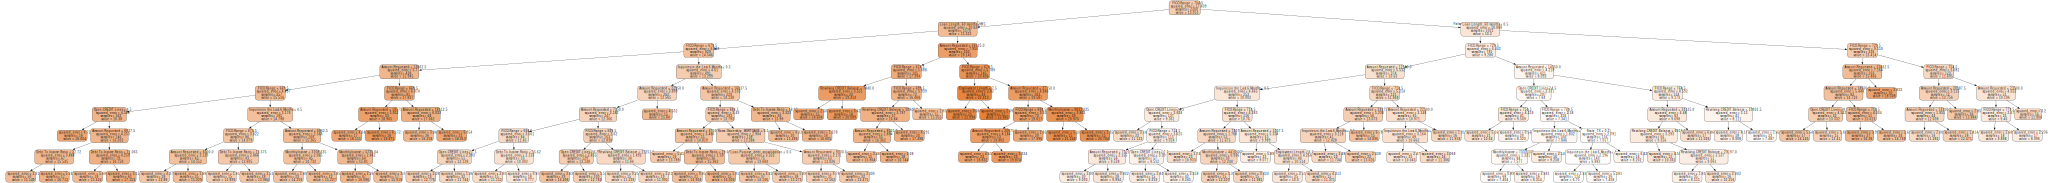

In [10]:
from sklearn.tree import export_graphviz
import graphviz

# Generate DOT data
dot_data = export_graphviz(
    dt,
    out_file=None,  # No file output, just return as a string
    feature_names=x_train.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    special_characters=True
)

# Render with Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png", cleanup=True)  # Saves as a high-quality PNG
graph  # Display in Jupyter Notebook (if applicable)

In [12]:
from sklearn.tree import export_text

tree_rules = export_text(dt, feature_names=list(x_train.columns))
print(tree_rules)

|--- FICO.Range <= 704.50
|   |--- Loan.Length_60 months <= 0.50
|   |   |--- FICO.Range <= 679.50
|   |   |   |--- Amount.Requested <= 13062.50
|   |   |   |   |--- FICO.Range <= 669.50
|   |   |   |   |   |--- Open.CREDIT.Lines <= 4.50
|   |   |   |   |   |   |--- value: [18.00]
|   |   |   |   |   |--- Open.CREDIT.Lines >  4.50
|   |   |   |   |   |   |--- Amount.Requested <= 6037.50
|   |   |   |   |   |   |   |--- Debt.To.Income.Ratio <= 22.72
|   |   |   |   |   |   |   |   |--- value: [15.15]
|   |   |   |   |   |   |   |--- Debt.To.Income.Ratio >  22.72
|   |   |   |   |   |   |   |   |--- value: [16.71]
|   |   |   |   |   |   |--- Amount.Requested >  6037.50
|   |   |   |   |   |   |   |--- Debt.To.Income.Ratio <= 11.07
|   |   |   |   |   |   |   |   |--- value: [15.42]
|   |   |   |   |   |   |   |--- Debt.To.Income.Ratio >  11.07
|   |   |   |   |   |   |   |   |--- value: [17.15]
|   |   |   |   |--- FICO.Range >  669.50
|   |   |   |   |   |--- Inquiries.in.the.Last.6.Mo

In [13]:
x_train.columns

Index(['Loan.Length_36 months', 'Loan.Length_60 months',
       'Loan.Purpose_debt_consolidation', 'Loan.Purpose_credit_card',
       'Loan.Purpose_other', 'Loan.Purpose_home_improvement',
       'Loan.Purpose_major_purchase', 'Loan.Purpose_small_business',
       'Loan.Purpose___other__', 'Loan.Purpose_car', 'Loan.Purpose_wedding',
       'Loan.Purpose_medical', 'State_CA', 'State_NY', 'State___other__',
       'State_FL', 'State_TX', 'State_PA', 'State_IL', 'State_GA', 'State_NJ',
       'State_VA', 'State_MA', 'State_NC', 'State_OH', 'State_MD', 'State_CO',
       'State_WA', 'State_CT', 'State_AZ', 'State_MI', 'State_AL', 'State_MN',
       'State_NV', 'State_MO', 'State_SC', 'State_OR',
       'Home.Ownership_MORTGAGE', 'Home.Ownership_RENT', 'Home.Ownership_OWN',
       'Amount.Requested', 'Open.CREDIT.Lines', 'Revolving.CREDIT.Balance',
       'Monthly.Income', 'Inquiries.in.the.Last.6.Months',
       'Debt.To.Income.Ratio', 'FICO.Range', 'Employment.Length'],
      dtype='objec

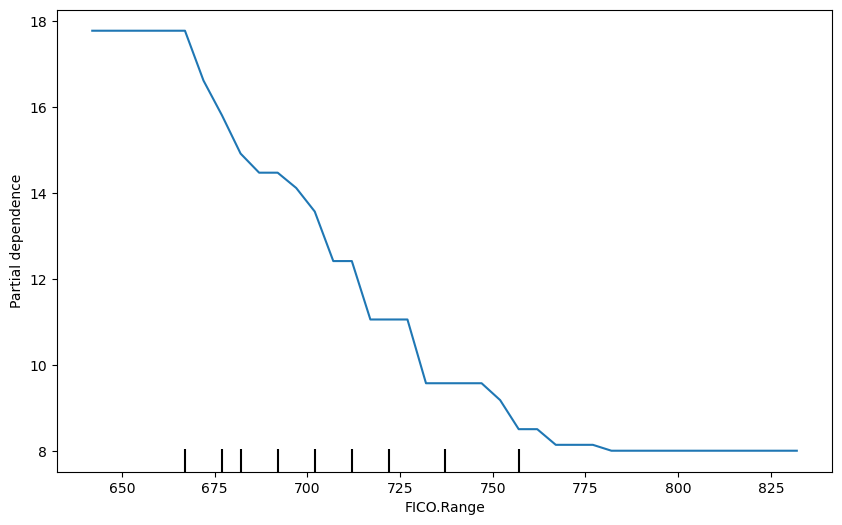

In [14]:
feature_to_plot = ['FICO.Range']  # Replace with actual feature name

# Plot Partial Dependence
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(dt, x_train, feature_to_plot, ax=ax,kind='average')
plt.show()

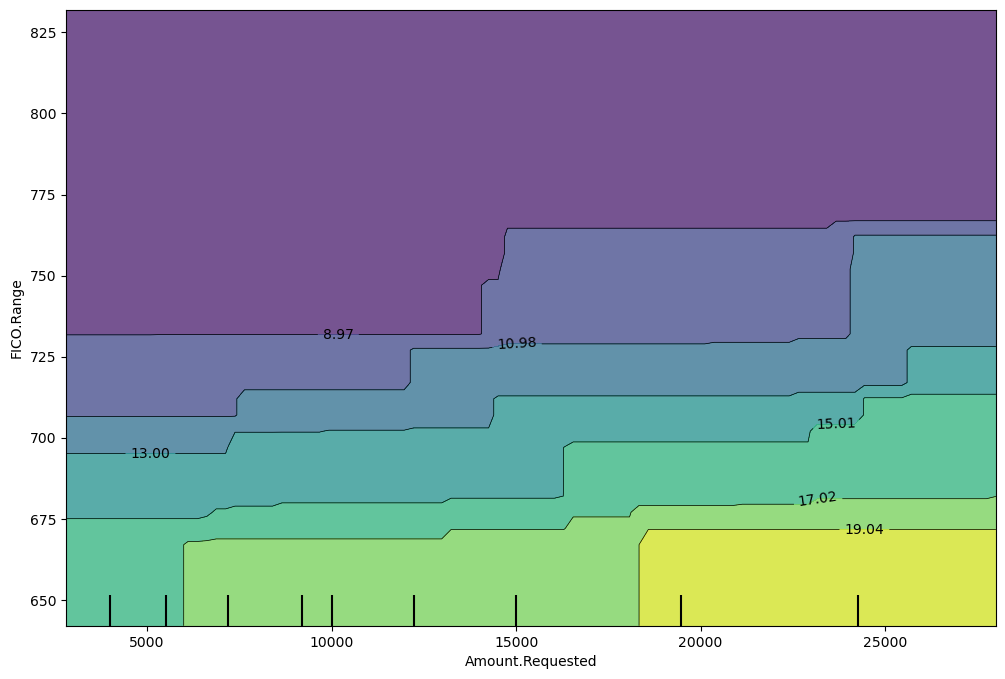

In [15]:
features = [('Amount.Requested', 'FICO.Range')]  # Replace with actual column names

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(dt, x_train, features, ax=ax, kind="average")
plt.show()

# Regression Forest

In [16]:
x_train.shape

(2200, 48)

In [ ]:
params_rf={
        'n_estimators':[50,100,150,200,250,300], # 6
        'max_features':[2,5,10,15,20,30,40,48],  # 7
        'bootstrap': [True,False], # 2
        'max_depth':[None,5,6,7,8,10,15,20,30,50], # 10
        'min_samples_leaf':[1,2,5,10,15,20], # 6
        'min_samples_split':[2,5,10,15,20] # 5
}

In [18]:
reg_rf=RandomForestRegressor()

In [19]:
rs_rf=RandomizedSearchCV(reg_rf,
                        cv=10,
                        param_distributions=params_rf,
                        scoring='neg_mean_absolute_error',
                        n_iter=50,
                        n_jobs=-1,
                        verbose=20)

In [20]:
rs_rf.fit(x_train,y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 5, 6, 7, 8, 10, 15,
                                                      20, 30, 50],
                                        'max_features': [2, 5, 10, 15, 20, 30,
                                                         40, 48],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300]},
                   scoring='neg_mean_absolute_error', verbose=20)

In [21]:
mt.report(rs_rf.cv_results_,5)

Model with rank: 1
Mean validation score: -1.351440 (std: 0.117811)
Parameters: {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 30, 'max_depth': 50, 'bootstrap': True}

Model with rank: 2
Mean validation score: -1.355472 (std: 0.118964)
Parameters: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 48, 'max_depth': 15, 'bootstrap': True}

Model with rank: 3
Mean validation score: -1.358018 (std: 0.117852)
Parameters: {'n_estimators': 250, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 30, 'max_depth': 8, 'bootstrap': True}

Model with rank: 4
Mean validation score: -1.365087 (std: 0.119776)
Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 40, 'max_depth': 7, 'bootstrap': True}

Model with rank: 5
Mean validation score: -1.371320 (std: 0.118660)
Parameters: {'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 15, 'max_features': 40, 'ma

In [22]:
reg_rf=RandomForestRegressor(**{'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 40, 'max_depth': 8, 'bootstrap': True})

In [23]:
reg_rf.fit(x_train,y_train)

RandomForestRegressor(max_depth=8, max_features=40, min_samples_leaf=5,
                      min_samples_split=15, n_estimators=200)

In [24]:
feat_imp_df=pd.DataFrame({'features':x_train.columns,'importance':reg_rf.feature_importances_})

In [ ]:
feat_imp_df.sort_values(by='importance',ascending=False,inplace=True)
feat_imp_df['cum_importance']=feat_imp_df['importance'].cumsum()
feat_imp_df

,features,importance,cum_importance
46,FICO.Range,0.633210,0.633210
1,Loan.Length_60 months,0.145007,0.778216
40,Amount.Requested,0.085120,0.863337
0,Loan.Length_36 months,0.061419,0.924755
44,Inquiries.in.the.Last.6.Months,0.019378,0.944134
41,Open.CREDIT.Lines,0.017926,0.962059
42,Revolving.CREDIT.Balance,0.009675,0.971734
45,Debt.To.Income.Ratio,0.009616,0.981350
43,Monthly.Income,0.007460,0.988811
47,Employment.Length,0.004158,0.992969


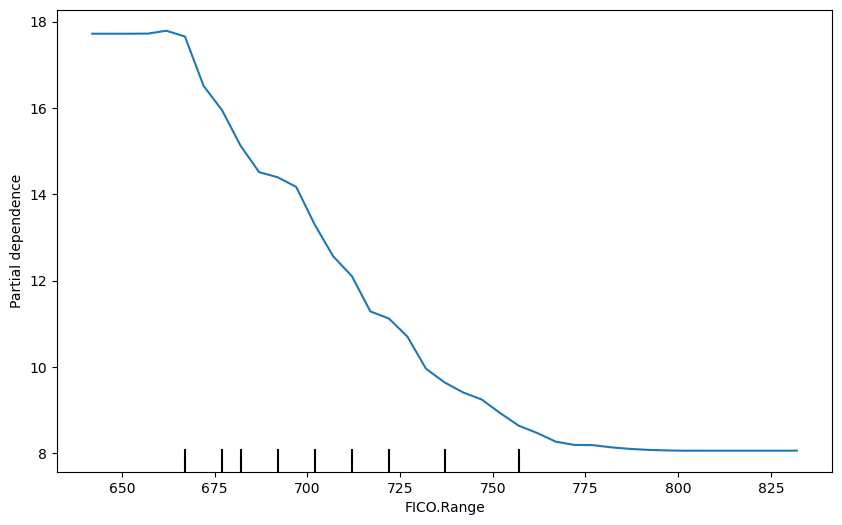

In [26]:
feature_to_plot = ['FICO.Range']  # Replace with actual feature name

# Plot Partial Dependence
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(reg_rf, x_train, feature_to_plot, ax=ax,kind='average')
plt.show()

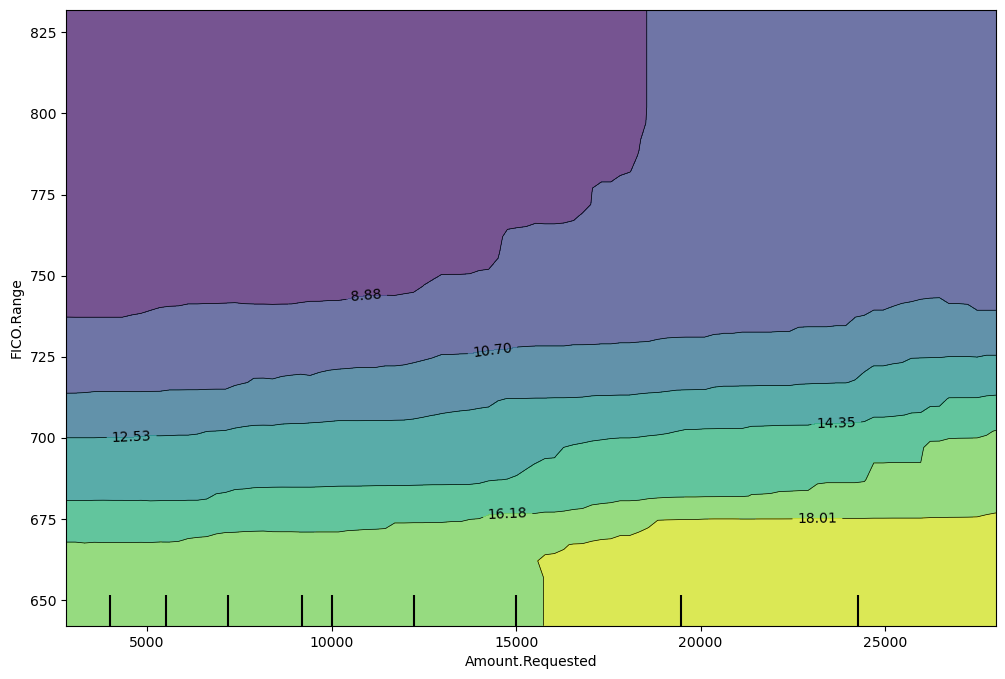

In [ ]:
features = [('Amount.Requested', 'FICO.Range')]  # Replace with actual column names

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rs_rf, x_train, features, ax=ax, kind="average")
plt.show()